## <span style="color:green"><h1><center>Downloading NOAA Precipiation for a Watershed </center></h1></span>
<center>Prepared by <br>
    <b>Jibin Joseph and Venkatesh Merwade</b><br> 
Lyles School of Civil Engineering, Purdue University<br>
joseph57@purdue.edu, vmerwade@purdue.edu<br>
<b><br>
    FAIR Science in Water Resources</b><br></center>


In [13]:
from pynhd import NLDI
import os
#from pygeohydro import NWIS
import requests
import pandas as pd
import time
import re

[-86.85134733  40.21639442 -85.73843254  40.53499477]
                                                        geometry   site_id
identifier                                                                
USGS-03335000  POLYGON ((-86.84133 40.41831, -86.84443 40.424...  03335000
Index(['geometry', 'site_id'], dtype='object')


In [ ]:
## USGS Site Number
site_id='03335000'

# Date range for the precipitation data
start_date = '2024-01-01'
end_date = '2024-12-31'

watershed=NLDI().get_basins(site_id,fsource='nwissite')
extents_basin=watershed.total_bounds
print(extents_basin)
## Adding site_id to geodataframe
watershed["site_id"]=site_id

## Adding other details
#nwis = NWIS()
#site_info = nwis.get_info({"site": site_id}, expanded=True)


#watershed["site_nm"] = site_info["station_nm"].iloc[0]
#watershed["site_lon"] = site_info["dec_long_va"].iloc[0]  
#watershed["site_lat"] = site_info["dec_lat_va"].iloc[0]
#watershed["dr_ar_sqmi"]=site_info["drain_area_va"].iloc[0]
#watershed["hcdn_2009"]=site_info["hcdn_2009"].iloc[0]

print(watershed.head())
print(watershed.columns)

# Output folder for CSVs
folder_output = f'data_{site_id}'
os.makedirs(folder_output, exist_ok=True)
shapefile_fileloc_filename=f"./{folder_output}/shape_{site_id}.shp"
watershed.to_file(filename=shapefile_fileloc_filename,
                 driver="ESRI Shapefile",
                 mode="w")

In [4]:
# Calculate centroids for each geometry
watershed['centroid'] = watershed.geometry.centroid

# Show result
print(watershed[['geometry', 'centroid']])


                                                        geometry  \
identifier                                                         
USGS-03335000  POLYGON ((-86.84133 40.41831, -86.84443 40.424...   

                                 centroid  
identifier                                 
USGS-03335000  POINT (-86.32213 40.38912)  


/tmp/ipykernel_159/537578335.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  watershed['centroid'] = watershed.geometry.centroid


In [5]:


# NOAA API token (get yours here: https://www.ncdc.noaa.gov/cdo-web/token)
API_TOKEN = 'BzJUVDNQCXcethBKDLveceOBxuaTHfxq'

# Define bounding box (minlon, minlat, maxlon, maxlat)
#bbox = [-125, 30, -65, 50]  # Example: USA lower 48 states
bbox = extents_basin

# Define request headers
headers = {'token': API_TOKEN}

# Base URL for NOAA NCEI API stations endpoint
base_url = 'https://www.ncei.noaa.gov/cdo-web/api/v2/stations'

# Parameters for the request
params = {
    'datasetid': 'GHCND',         # Global Historical Climatology Network - Daily
    'extent': f'{bbox[1]},{bbox[0]},{bbox[3]},{bbox[2]}',  # lat1, lon1, lat2, lon2
    'limit': 1000,                # Max records per request
    'offset': 1,                  # Start offset
}

all_stations = []
page = 1

while True:
    print(f'Fetching page {page} with offset {params["offset"]}...')

    response = requests.get(base_url, headers=headers, params=params)

    if response.status_code != 200:
        print(f'Error: {response.status_code} - {response.text}')
        break

    data = response.json()

    # Check if there are results
    if 'results' not in data or not data['results']:
        print('No more stations to fetch.')
        break

    all_stations.extend(data['results'])

    # Pagination: increase offset by limit
    params['offset'] += params['limit']
    page += 1

    # NOAA rate limits: be kind
    time.sleep(1)

# Convert results to pandas DataFrame
df = pd.DataFrame(all_stations)

# Select desired columns (if they exist)
selected_columns = ['id', 'name', 'latitude', 'longitude', 'elevation', 'mindate', 'maxdate']
df_selected = df[selected_columns].copy()

# Rename columns if you want
df_selected.rename(columns={
    'id': 'Station ID',
    'latitude': 'Station_Lat',
    'longitude': 'Station_Lon',
    'mindate': 'Start Date',
    'maxdate': 'End Date',
    'elevation': 'Elevation'
}, inplace=True)

# Display and save
print(df_selected.head())

df_selected.to_csv(f"./{folder_output}/noaa_all_stations.csv", index=False)

print(f'Download complete: {len(df_selected)} stations saved to noaa_all_stations.csv in {folder_output} folder')


Fetching page 1 with offset 1...
Fetching page 2 with offset 1001...
No more stations to fetch.
          Station ID                      name  Station_Lat  Station_Lon  \
0  GHCND:US1INCL0001    ROSSVILLE 5.3 E, IN US    40.416467   -86.494307   
1  GHCND:US1INCL0002  ROSSVILLE 3.9 SSE, IN US    40.366361   -86.576370   
2  GHCND:US1INCL0008  LAFAYETTE 9.1 ENE, IN US    40.425036   -86.693964   
3  GHCND:US1INCL0009  ROSSVILLE 1.9 SSW, IN US    40.395294   -86.608653   
4  GHCND:US1INCL0010  FRANKFORT 7.9 WSW, IN US    40.254382   -86.656652   

   Elevation  Start Date    End Date  
0      238.0  2006-04-05  2007-08-25  
1      249.9  2006-04-04  2007-01-15  
2      206.3  2009-03-16  2010-09-03  
3      224.9  2010-05-14  2011-09-25  
4      256.6  2010-07-12  2013-03-25  
Download complete: 59 stations saved to noaa_all_stations.csv in data_03335000 folder


In [6]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
# Convert to pandas DataFrame first
#df = pd.DataFrame(all_stations)

# Create a geometry column from Station_Lon and Station_Lat
geometry = [Point(xy) for xy in zip(df_selected['Station_Lon'], df_selected['Station_Lat'])]

# Create GeoDataFrame
gdf_all = gpd.GeoDataFrame(df_selected, geometry=geometry)

# Set a CRS (Coordinate Reference System), assuming WGS84 (EPSG:4326)
gdf_all.set_crs(epsg=4326, inplace=True)

# Show the GeoDataFrame
print(len(gdf_all))
print(gdf_all.head())



df_active=df_selected[df_selected['End Date']>=end_date]
df_active.to_csv(f"./{folder_output}/noaa_active_stations.csv", index=False)
# Create a geometry column from Station_Lon and Station_Lat
geometry = [Point(xy) for xy in zip(df_active['Station_Lon'], df_active['Station_Lat'])]

# Create GeoDataFrame
gdf_active = gpd.GeoDataFrame(df_active, geometry=geometry)

# Set a CRS (Coordinate Reference System), assuming WGS84 (EPSG:4326)
gdf_active.set_crs(epsg=4326, inplace=True)

# Show the GeoDataFrame
print(len(gdf_active))
print(gdf_active.head())

59
          Station ID                      name  Station_Lat  Station_Lon  \
0  GHCND:US1INCL0001    ROSSVILLE 5.3 E, IN US    40.416467   -86.494307   
1  GHCND:US1INCL0002  ROSSVILLE 3.9 SSE, IN US    40.366361   -86.576370   
2  GHCND:US1INCL0008  LAFAYETTE 9.1 ENE, IN US    40.425036   -86.693964   
3  GHCND:US1INCL0009  ROSSVILLE 1.9 SSW, IN US    40.395294   -86.608653   
4  GHCND:US1INCL0010  FRANKFORT 7.9 WSW, IN US    40.254382   -86.656652   

   Elevation  Start Date    End Date                    geometry  
0      238.0  2006-04-05  2007-08-25  POINT (-86.49431 40.41647)  
1      249.9  2006-04-04  2007-01-15  POINT (-86.57637 40.36636)  
2      206.3  2009-03-16  2010-09-03  POINT (-86.69396 40.42504)  
3      224.9  2010-05-14  2011-09-25  POINT (-86.60865 40.39529)  
4      256.6  2010-07-12  2013-03-25  POINT (-86.65665 40.25438)  
14
           Station ID                      name  Station_Lat  Station_Lon  \
5   GHCND:US1INCL0014  FRANKFORT 4.9 NNE, IN US    40.3503

In [8]:
import matplotlib.pyplot as plt
# Check CRS consistency
print("Watershed CRS:", watershed.crs)
print("Stations CRS:", gdf_all.crs)

Watershed CRS: EPSG:4326
Stations CRS: EPSG:4326


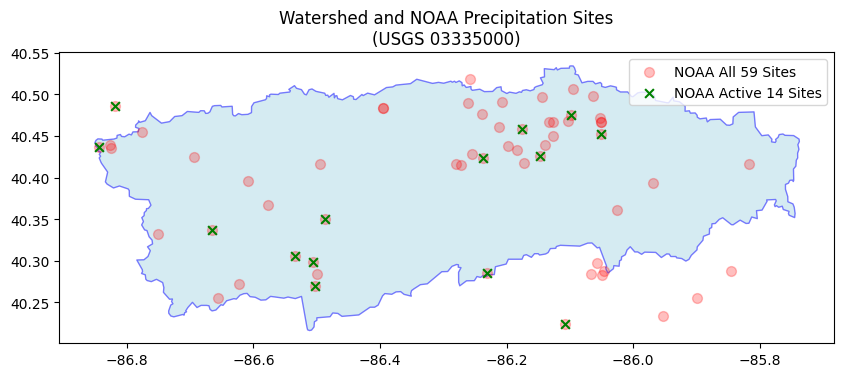

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the watershed polygons
watershed.plot(ax=ax, color='lightblue', edgecolor='blue', alpha=0.5, linewidth=1)

# Plot the stations as points
gdf_all.plot(ax=ax, color='red', markersize=50, marker='o', label=f'NOAA All {len(gdf_all)} Sites ',alpha=0.25)
gdf_active.plot(ax=ax, color='green', markersize=40, marker='x', label=f'NOAA Active {len(gdf_active)} Sites',alpha=1)

# Add titles and legend
ax.set_title(f"Watershed and NOAA Precipitation Sites\n(USGS {site_id})")#: {site_info['station_nm'].iloc[0]}\nDrainage Area: {round(site_info['drain_area_va'].iloc[0],2)} sq. mi.)")
ax.legend()
# Save the figure as a PNG file
plt.savefig(f"./{folder_output}/{site_id}_plot_image.png")

In [12]:


# Request headers
headers = {'token': API_TOKEN}

# Base URL for data endpoint
base_url = 'https://www.ncei.noaa.gov/cdo-web/api/v2/data'



# Dataset and datatype
datasetid = 'GHCND'  # Global Historical Climatology Network - Daily
datatypeid = 'PRCP'  # Precipitation

print(len(df_selected))
#print((stations_df.head()))

print(len(df_active))
print((df_active.head()))

59
14
           Station ID                      name  Station_Lat  Station_Lon  \
5   GHCND:US1INCL0014  FRANKFORT 4.9 NNE, IN US    40.350300   -86.486700   
7   GHCND:US1INCL0018   MULBERRY 0.6 SSE, IN US    40.337204   -86.664883   
8   GHCND:US1INCL0019  FRANKFORT 0.9 SSE, IN US    40.269500   -86.502400   
9   GHCND:US1INCL0020   FRANKFORT 2.1 NW, IN US    40.306074   -86.534186   
12  GHCND:US1INHW0003     KOKOMO 4.6 ESE, IN US    40.452784   -86.050761   

    Elevation  Start Date    End Date  
5       272.5  2012-03-11  2025-03-10  
7       235.0  2021-04-29  2025-03-09  
8       261.8  2022-01-09  2025-03-10  
9       252.7  2022-01-01  2025-03-09  
12      257.9  2006-12-17  2025-03-10  


In [16]:
# Output folder for CSVs
output_folder = 'station_precip_data'
os.makedirs(output_folder, exist_ok=True)

# Function to sanitize filename
def sanitize_filename(name):
    return re.sub(r'[^\w\-_\. ]', '_', name)

# Loop through each station
for index, row in df_active.iterrows():
    station_id = row['Station ID']
    print(f"\nDownloading PRCP data for station {station_id} ({index + 1}/{len(df_active)})")

    # Prepare parameters for each station
    params = {
        'datasetid': datasetid,
        'datatypeid': datatypeid,
        'stationid': station_id,
        'startdate': start_date,
        'enddate': end_date,
        'limit': 1000,
        'offset': 1,
        'units': 'standard'  # or 'metric'
    }

    station_data = []
    page = 1

    while True:
        print(f"Fetching page {page} for {station_id} with offset {params['offset']}...")

        response = requests.get(base_url, headers=headers, params=params)

        if response.status_code != 200:
            print(f"Error for station {station_id}: {response.status_code} - {response.text}")
            break

        data = response.json()

        if 'results' not in data or not data['results']:
            print(f"No more data for station {station_id}.")
            break

        station_data.extend(data['results'])

        # Pagination: increase offset by limit
        params['offset'] += params['limit']
        page += 1

        # Respect NOAA rate limits
        time.sleep(2)

    if station_data:
        # Convert to DataFrame
        station_df = pd.DataFrame(station_data)
        station_df['Station ID'] = station_id  # Add station ID to each row

        # Clean station ID for filename (remove colons, slashes, etc.)
        clean_station_id = sanitize_filename(station_id)

        # Build file path
        output_file = f"./{folder_output}/{clean_station_id}.csv"

        # Save to CSV
        station_df.to_csv(output_file, index=False)
        print(f"Saved {len(station_df)} records to {output_file}")
    else:
        print(f"No precipitation data found for station {station_id}.")

print("\nDownload complete for all stations.")


Fetching page 1 for GHCND:US1INCL0014 with offset 1...
Error for station GHCND:US1INCL0014: 503 - <!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">
<html><head>
<title>503 Service Unavailable</title>
</head><body>
<h1>Service Unavailable</h1>
<p>The server is temporarily unable to service your
request due to maintenance downtime or capacity
problems. Please try again later.</p>
<p>Additionally, a 503 Service Unavailable
error was encountered while trying to use an ErrorDocument to handle the request.</p>
</body></html>

No precipitation data found for station GHCND:US1INCL0014.

Fetching page 1 for GHCND:US1INCL0018 with offset 1...
Fetching page 2 for GHCND:US1INCL0018 with offset 1001...
Error for station GHCND:US1INCL0018: 503 - <!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">
<html><head>
<title>503 Service Unavailable</title>
</head><body>
<h1>Service Unavailable</h1>
<p>The server is temporarily unable to service your
request due to maintenance downtime or capacity
problems. 

In [17]:
annual_total=[]

for index, row in df_active.iterrows():
    station_id = row['Station ID']
    # Clean station ID for filename (remove colons, slashes, etc.)
    clean_station_id = sanitize_filename(station_id)

    try:
        df = pd.read_csv(f"/glade/u/home/jjoseph/prec_noaa_dataaccess/{folder_output}/{clean_station_id}.csv")

    
        # Convert 'date' to datetime
        df['date'] = pd.to_datetime(df['date'])
    
        # Extract the year
        df['year'] = df['date'].dt.year
    
        # Inspect data
        #print(df.head())

        # Group by station and year, sum the precipitation values
        annual_precip = df.groupby(['Station ID', 'year'])['value'].sum().reset_index()
        
        # Rename columns for clarity
        annual_precip.columns = ['Station ID', 'Year', 'Annual_Total_Precip']
        
        # Display result
        print(annual_precip)

    except Exception as e:
            #print(f"Error processing {station_id}: {e}")
            continue


In [88]:
!pwd

/glade/u/home/jjoseph/prec_noaa_dataaccess


In [63]:
!zip -r data_03335000.zip data_03335000

  adding: data_03335000/ (stored 0%)
  adding: data_03335000/GHCND_US1INHW0039.csv (deflated 94%)
  adding: data_03335000/noaa_all_stations.csv (deflated 67%)
  adding: data_03335000/03335000_plot_image.png (deflated 12%)
  adding: data_03335000/GHCND_US1INTN0012.csv (deflated 94%)
  adding: data_03335000/.ipynb_checkpoints/ (stored 0%)
  adding: data_03335000/.ipynb_checkpoints/03335000_plot_image-checkpoint.png (deflated 12%)
  adding: data_03335000/GHCND_US1INHW0040.csv (deflated 94%)
  adding: data_03335000/noaa_active_stations.csv (deflated 60%)
  adding: data_03335000/GHCND_USC00128784.csv (deflated 94%)
  adding: data_03335000/GHCND_USC00123082.csv (deflated 94%)
  adding: data_03335000/GHCND_US1INCL0014.csv (deflated 94%)
  adding: data_03335000/shape_03335000.shx (deflated 45%)
  adding: data_03335000/GHCND_US1INHW0003.csv (deflated 94%)
  adding: data_03335000/GHCND_USC00124662.csv (deflated 94%)
  adding: data_03335000/shape_03335000.prj (deflated 17%)
  adding: data_0333500